#Setup (and The Pseudocode)

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter

#from sqrtm import sqrtm
from numpy.linalg import  matrix_rank as rank
from scipy.integrate import odeint


import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)  
#Reference : https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/


**Input** : A sequence of step sizes and clipping thresholds $\{ (\eta_t, \tau_t) \}_{t=1,2..}$, an initial starting point $\vec{x}_1 \in \mathbb{R}^d$, and we are given oracle access to the gradients of $f : \mathbb{R}^d \rightarrow \mathbb{R}$.

**Input** : A distribution ${\cal D}$ to sample noise from. 

**Noisy-GClip** ($\vec{x}_1, \{ (\eta_t, \tau_t) \}_{t=1,2..}, {\cal D}$)


For ($t = 1, 2, \ldots$}
   - Sample a noise random variable $\xi_t \sim {\cal D}$ 
   - Form the noisy gradient as $\vec{g}_t = \xi_t + \nabla f (\vec{x}_t)$
   - $\vec{x}_{t+1} = \vec{x}_{t} - \eta_t \min \left \{ 1 , \frac{\tau_t}{\Vert{\vec{g}_t} \Vert} \right \} \vec{g}_t$

#A Strongly-Convex Example, $f = (a x)^2 + (b x^2)^2$

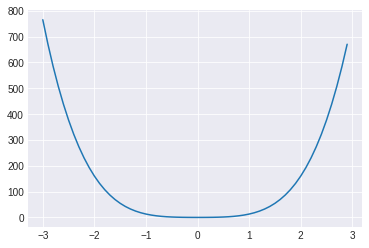

In [2]:

a = 2
b = 3 

#Although not particularly needed for this example - its in general a good idea to define 2 versions of the objective function 
#- one that can handle tensor inputs for optimization
#- one that can be used by matplotlib which only deals with numpy arrays 
#In the non-convex example that we shall see later, we shall face a real need for having these two versions 

f_torch = lambda x: (a **2)* x**2 + (b**2)*(x**4) 
f_np = lambda x: (a **2)* x**2 + (b**2)*(x**4) 

domain = torch.arange(-3.0, 3.0, 0.1)
plt.plot(domain, f_torch(domain))
plt.grid(True)

##Running The Noisy GClip Optimizer

In [6]:
eta = 10**(-3) 
#A constant step-length eta 
d = 1 
#domain dimension of the function 
steps  = int(10**4) 
#how many times the algorithm takes a GClip step/an algorithmic update 
tau = 1.0 
#A constant clipping threshold tau 


gap = 1 
#after how many steps the progress is recorded 

grad_clip = 1 
#switching the above to 0 will make the code do noisy gradient descent 
noise = 1.5 
#switching the above to 0 will stop noise addition in the gradient 

x_data = (2.5)*torch.ones((d, )) + 0.01*torch.randn((d, )) 
#x_1 in the pseudocode - here chosen as a weighted combination of the all-ones vector and a random-normal sample 
x_data.requires_grad_(True) 
#Tells PyTorch that we shall take derivatives w.r.t x_data 

optimizer = optim.SGD([x_data], eta) 
#optimizer will take the gradient of the function it is called on at x_data 
#-this way we shall be using the inbuilt SGD functionality to compute gradients of our function whose minima we are seeking.  

trajectory_x = []
#the above list will store the sequence of points through which the algorithm travels 

for iter in range(steps):
    if iter % gap == 0 or iter == steps-1:
        trajectory_x.append(np.array(x_data.data[0])) 
        #Recall that x_data is a PyTorch tensor - so that needs a bit of a careful handling! 
        #x_data.data[0] is a PyTorch technicality to ensure we are exacting only the numerical information contained in x_data i.e the current coordinate of the algorithm.  
        #(x_data being a PyTorch tensor has a whole lot of other stuff in it too.) 

    out = f_torch(x_data) 
    #out evaluates the target function at the current location x_data 
    optimizer.zero_grad() 
    #this is a PyTorch technicality to remove any information about previous gradients 
    out.backward() 
    #This computes the derivative df/dx at x = x_data and assigns the gradient value to an internal variable called x_data.grad 
    #What was \nabla f (x_t) in the pseudocode above is out.backward() inside the code - stored as x_data.grad 
   
    x_data.grad.add_(noise * torch.randn_like(x_data)) 
    #add a random Normal noise (scaled by the coefficient "noise") to the current gradient stored at x_data.grad 
    #Now x_data.grad becomes what was g_t in the pseudocode 

    #gradient clipping
    if grad_clip:
        x_data.grad.mul_(min(1.0, tau/torch.norm(x_data.grad).data)) 
        #x.data.grad is updated to the GClip update direction i.e min{1,tau/norm(g_t)}g_t where g_t = df/dx at x_data 
        #Here again we see how the ".data" code is used to extract the numerical data part of the PyTorch tensor torch.norm(x_data.grad)

    optimizer.step() 
    #This does the update of x_{t+1} = x_t - eta * x_data.grad = x_t - eta*min{1,tau/norm(g_t)}g_t
    #x_data changes to x_{t+1} 

## The Trajectory Plotter (Takes ~ 45 seconds to run for 10,000 steps) 

Text(0, 0.5, '$f(x)$')

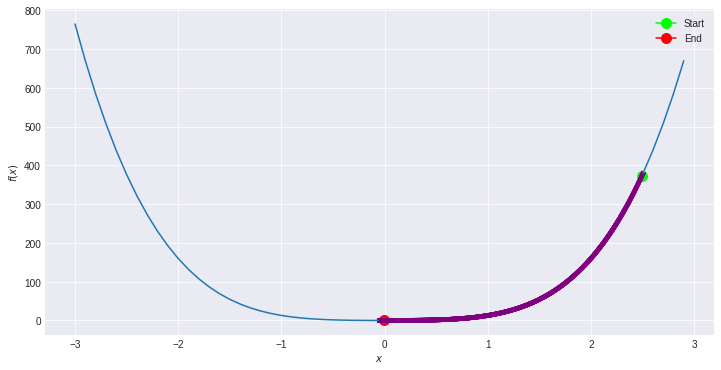

In [7]:
#Note that here we use the numpy version of the function f i.e f_np defined earlier 

fig, ax = plt.subplots(figsize=(12,6)) 
#Single plot will be created of size 12 (horizontal) x 6 (vertical) size 
domain_np = np.arange(-3, 3, 0.1) 
#The x-axis will be a grid of gap 0.1 on the interval [-3,3] 

ax.plot([trajectory_x[0]], [f_np(trajectory_x[0])], marker='o', markersize=10, c='lime', label="Start")
#The above marks the start point with lime coloured disc - and creates a legend "Start" for this 

for j in range(1, len(trajectory_x)-1): 
    #We plot one point for each element in the stored path in the trajectory_x array exacept for the Start (above) and the end-point 

    ax.annotate('', xy=(trajectory_x[j], f_np(trajectory_x[j])), xytext=(trajectory_x[j-1], f_np(trajectory_x[j-1])), arrowprops={'arrowstyle': '->', 'color': 'purple', 'lw': 0.8})
    #The above command creates purple coloured arrows from the point (x_{t-1},f(x_{t-1})) (``xytext" attribute) to (x_t,f(x_t)) ("xy" attribute) above.  

ax.plot([trajectory_x[-1]], [f_np(trajectory_x[-1])], marker='o',markersize=10, c='red', label="End")
#The above marks the end point of the algorithm with a red coloured disc -  and creates a legend "End" for this

ax.plot(domain_np, f_np(domain_np))
#The above plots the objective function itself 

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#The above types in the legends on the axis 

# A Non-Convex Example, $f = 1 - e^{-c \cdot x^2} - p \cdot e^{-(x-a)^2}$

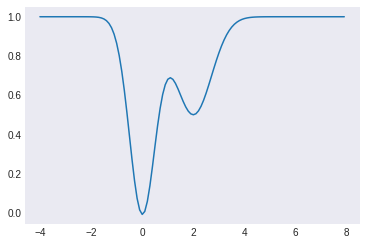

In [8]:
c = 2
p = 0.5
a = 2

#We need 2 versions of the function to be defined 
#- one that can handle tensor inputs for optimization
#- one that can be used by matplotlib which only deals with numpy arrays 

f_torch = lambda x: 1 - torch.exp(-c * x**2) - p * torch.exp(-(x-a)**2) 
f_np = lambda x: 1 - np.exp(-c * x**2) - p * np.exp(-(x-a)**2) 

domain = torch.arange(-4.0, 8.0, 0.1)
plt.plot(domain, f_torch(domain))
plt.grid()

##Running The Noisy GClip Optimizer 



In [9]:
eta = 10**(-3) 
#A constant step-length eta 
d = 1 
#domain dimension of the function 
steps  = int(10**4) 
#how many times the algorithm takes a GClip step/an algorithmic update 
tau = 1.0 
#A constant clipping threshold tau 


gap = 1 
#after how many steps the progress is recorded 

grad_clip = 1 
#switching the above to 0 will make the code do noisy gradient descent 
noise = 1.5 
#switching the above to 0 will stop noise addition in the gradient 

x_data = (1.5)*torch.ones((d, )) + 0.01*torch.randn((d, )) 
#x_1 in the pseudocode - here chosen as a weighted combination of the all-ones vector and a random-normal sample 
x_data.requires_grad_(True) 
#Tells PyTorch that we shall take derivatives w.r.t x_data 

optimizer = optim.SGD([x_data], eta) 
#optimizer will take the gradient of the function it is called on at x_data 
#-this way we shall be using the inbuilt SGD functionality to compute gradients of our function whose minima we are seeking.  

trajectory_x = []
#the above list will store the sequence of points through which the algorithm travels 

for iter in range(steps):
    if iter % gap == 0 or iter == steps-1:
        trajectory_x.append(np.array(x_data.data[0])) 
        #Recall that x_data is a PyTorch tensor - so that needs a bit of a careful handling! 
        #x_data.data[0] is a PyTorch technicality to ensure we are exacting only the numerical information contained in x_data i.e the current coordinate of the algorithm.  
        #(x_data being a PyTorch tensor has a whole lot of other stuff in it too.) 

    out = f_torch(x_data) 
    #out evaluates the target function at the current location x_data 
    optimizer.zero_grad() 
    #this is a PyTorch technicality to remove any information about previous gradients 
    out.backward() 
    #This computes the derivative df/dx at x = x_data and assigns the gradient value to an internal variable called x_data.grad 
    #What was \nabla f (x_t) in the pseudocode above is out.backward() inside the code - stored as x_data.grad 
   
    x_data.grad.add_(noise * torch.randn_like(x_data)) 
    #add a random Normal noise (scaled by the coefficient "noise") to the current gradient stored at x_data.grad 
    #Now x_data.grad becomes what was g_t in the pseudocode 

    #gradient clipping
    if grad_clip:
        x_data.grad.mul_(min(1.0, tau/torch.norm(x_data.grad).data)) 
        #x.data.grad is updated to the GClip update direction i.e min{1,tau/norm(g_t)}g_t where g_t = df/dx at x_data 
        #Here again we see how the ".data" code is used to extract the numerical data part of the PyTorch tensor torch.norm(x_data.grad)

    optimizer.step() 
    #This does the update of x_{t+1} = x_t - eta * x_data.grad = x_t - eta*min{1,tau/norm(g_t)}g_t
    #x_data changes to x_{t+1} 

##The Trajectory Plotter 

Text(0, 0.5, '$f(x)$')

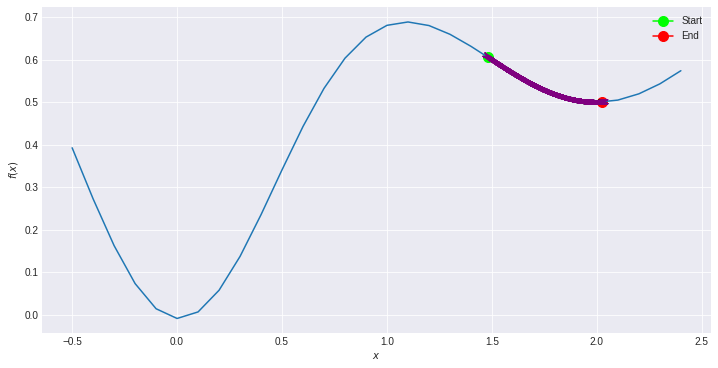

In [10]:
#Note that here we need the numpy version of the function f i.e f_np defined earlier 

fig, ax = plt.subplots(figsize=(12,6)) 
#Single plot will be created of size 12 (horizontal) x 6 (vertical) size 
domain_np = np.arange(-0.5, 2.5, 0.1) 
#The x-axis will be a grid of gap 0.1 on the interval [-0.5,2.5] 

ax.plot([trajectory_x[0]], [f_np(trajectory_x[0])], marker='o', markersize=10, c='lime', label="Start")
#The above marks the start point with lime coloured disc - and creates a legend "Start" for this 

for j in range(1, len(trajectory_x)-1): 
    #We plot one point for each element in the stored path in the trajectory_x array exacept for the Start (above) and the end-point 

    ax.annotate('', xy=(trajectory_x[j], f_np(trajectory_x[j])), xytext=(trajectory_x[j-1], f_np(trajectory_x[j-1])), arrowprops={'arrowstyle': '->', 'color': 'purple', 'lw': 0.8})
    #The above command creates purple coloured arrows from the point (x_{t-1},f(x_{t-1})) (``xytext" attribute) to (x_t,f(x_t)) ("xy" attribute) above.  

ax.plot([trajectory_x[-1]], [f_np(trajectory_x[-1])], marker='o',markersize=10, c='red', label="End")
#The above marks the end point of the algorithm with a red coloured disc -  and creates a legend "End" for this

ax.plot(domain_np, f_np(domain_np))
#The above plots the objective function itself 

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#The above types in the legends on the axis 